# TTM Squeeze Strategy
_Roshan Mahes (based on Larry Kubin's tutorial)._

This strategy is based on Larry Kubin's following tutorial:

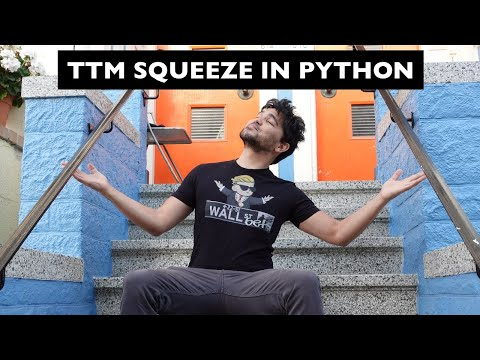

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('YhkNoOqYp9A', width=533, height=300)

In [5]:
%pip install plotly

The following packages are required:

In [6]:
import os
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go

In the file `Amsterdam.csv` we provided a list of companies listed in the _Amsterdam Exchange Index_ (AEX), _Amsterdam Midcap Index_ (AEX) and _Amsterdam Small Cap Index_ (AScX):

In [113]:
Amsterdam_df = pd.read_csv('symbols/Amsterdam.csv', sep=';')
Amsterdam_df

,Symbol,Company Name,Last Price,Change,% Change,Volume
0,NN.AS,NN Group N.V.,32.75,0.070,+0.21%,"1,426,693"
1,WKL.AS,Wolters Kluwer N.V.,68.20,-0.320,-0.47%,"659,034"
2,RDSA.AS,Royal Dutch Shell plc,12.26,-0.060,-0.47%,"14,257,842"
3,AKZA.AS,Akzo Nobel N.V.,81.66,-0.400,-0.49%,"493,146"
4,IMCD.AS,IMCD N.V.,88.16,-0.640,-0.72%,"135,69"
...,...,...,...,...,...,...
70,KA.AS,KA.AS,NaN,NaN,NaN,NaN
71,BINCK.AS,BINCK.AS,NaN,NaN,NaN,NaN
72,BRNL.AS,Brunel International N.V.,6.40,-0.100,-1.54%,"65,573"
73,TMG.AS,TMG.AS,NaN,NaN,NaN,NaN


We will use these stocks to test our strategy on. First we need to download the corresponding daily stock prices, starting from January 1st, 2020:

In [151]:
symbols = Amsterdam_df['Symbol']

# keep track of number of indices downloaded
symbol_index = 0

for symbol in symbols:
    
    symbol_index += 1
    print(f'Downloading symbol {symbol_index}/{len(symbols)}: {symbol}.')
    data = yf.download(symbol, start='2020-01-01')
    
    # don't store empty datasets
    if len(data):
        data.to_csv(f'data/{symbol}.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## The Strategy

_Volatility channels_ are a type of indicator that plot volatility-related lines above and below the market. These lines are variously known as channels, envelopes, or bands. They widen as volatility increases, and narrow as volatility decreases. The most well-known volatility channel are the _Bollinger Bands,_ though the _Keltner Channel_ Indicator is another effective type as well.

The channels or bands describe the outer boundaries of the normality of the price change. It also establishes where a band of likely support or resistance levels might lie. If the market breaks out beyond this boundary, we are alerted of an unusual occurrence and can plan our trades accordingly. There are numerous ways of using these bands to generate trade signals such as _Squeeze, Bounce, Walking the Bands, M-Tops_ and _W-Bottoms_ etc. We’ll be using a very effective method of detecting a change in the volatility of the market using the squeeze of Bollinger Bands and Keltner Channels, called the _TTM Squeeze indicator_.

### Bollinger Bands

Bollinger Bands, developed by John Bollinger, combine moving averages and standard deviations to detect a change in volatility of the market. There are three components to the Bollinger Band indicator:

- _Middle Line:_ $\text{20-day Simple Moving Average (SMA)}$
- _Upper Band:_ $\text{20-day SMA} + 2 \cdot Std$
- _Lower Band:_ $\text{20-day SMA} - 2 \cdot Std$

Because _standard deviation ($Std$)_ is a measure of volatility, when the markets become more volatile the bands widen while during less volatile periods, the bands contract. Many traders believe the closer the prices move to the upper band, the more overbought the market, and the closer the prices move to the lower band, the more oversold the market.


### Keltner's Channel

The Keltner Channel, invented by Chester Keltner, is also a volatility based technical indicator composed of three separate lines. Instead of using the standard deviation, Keltner Channels use the _Average True Range ($ATR$)_ to set channel distance. This is the $20$-day moving average of the absolute price difference each day. The following are the three components:

- _Middle Line:_ $\text{20-day Exponential Moving Average (EMA)}$
- _Upper Channel Line:_ $\text{20-day EMA} + 1.5 \cdot ATR$
- _Lower Channel Line:_ $\text{20-day EMA} - 1.5 \cdot ATR$

Keltner Channels and Bollinger Bands are quite similar. The general concept is that the farther the closing price is from the average closing price, the more volatile a market is deemed to be, and vice versa. That is what determines the degree of contraction or expansion of a Bollinger Band or a Keltner Channel.

### TTM Squeeze indicator
The strategy works as follows. The TTM Squeeze indicator measures the relationship between the Bollinger Bands and Keltner's Channel. When the volatility increases, so does the distance between the bands, and conversely, when the volatility declines, the distance also decreases.  The Squeeze indicator finds sections of the Bollinger Bands study which fall inside the Keltner's Channels.

At the moment this squeeze happens, a price breakout from the upper Bollinger Band would indicate the possibility of an uptrend in the future. This is backed by the fact that once the price starts breaking out of the bands, it would mean a relaxation of the squeeze and the possibility of high market volatility and price movement in the future. Similarly, a price breakout from the lower Bollinger Band after a squeeze would indicate the possibility of a downtrend in the future and an increased market volatility in the same direction. When the market finishes a move, the indicator turns off, which corresponds to bands having pushed well outside the range of Keltner's Channels.

Now let's implement the strategy, and apply it to the Amsterdam stocks:

In [182]:
for filename in os.listdir('data'):
    
    # check whether the stock is from Amsterdam
    if filename.split(".")[1] == 'AS':
        
        # load data
        symbol = filename.split(".")[0] + '.AS'
        df = pd.read_csv(f'data/{symbol}.csv')

        # compute Bollinger bands
        df['20sma'] = df['Close'].rolling(window=20).mean()
        df['std'] = df['Close'].rolling(window=20).std()

        df['low_bol'] = df['20sma'] - (2 * df['std'])
        df['upp_bol'] = df['20sma'] + (2 * df['std'])

        # compute Keltner's channel
        df['TR'] = abs(df['High'] - df['Low'])
        df['ATR'] = df['TR'].rolling(window=20).mean()
        
        df['low_kel'] = df['20sma'] - df['ATR'] * 1.5
        df['upp_kel'] = df['20sma'] + df['ATR'] * 1.5

        # squeeze indicator
        def in_squeeze(df):
            return df['low_kel'] < df['low_bol'] < df['upp_bol'] < df['upp_kel']

        df['squeeze'] = df.apply(in_squeeze, axis=1)

        # stock is coming out of the squeeze
        if df.iloc[-3]['squeeze'] and not df.iloc[-1]['squeeze']:
            
            # decide which action to take by comparing distances
            distance_to_upper = abs(df['upp_bol'].values[-1] - df['Close'].values[-1])
            distance_to_lower = abs(df['low_bol'].values[-1] - df['Close'].values[-1])
            
            if distance_to_upper < distance_to_lower:
                action = 'buy'
            else:
                action = 'sell'
            
            print(f'{symbol} is coming out of the squeeze. Advice: {action} stock.')
            
            # initialize figure
            candlestick = go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'],
                                         low=df['Low'], close=df['Close'], name='candles')

            upp_bol = go.Scatter(x=df['Date'], y=df['upp_bol'], name='Upper Bollinger Band', line={'color': 'darkblue'},
                                 fill='tonexty', fillcolor='rgba(0,0,255,0.1)')
            low_bol = go.Scatter(x=df['Date'], y=df['low_bol'], name='Lower Bollinger Band', line={'color': 'darkblue'})

            upp_kel = go.Scatter(x=df['Date'], y=df['upp_kel'], name='Upper Keltner Channel', line={'color': 'darkred'},
                                 fill='tonexty', fillcolor='rgba(255,0,0,0.1)')
            low_kel = go.Scatter(x=df['Date'], y=df['low_kel'], name='Lower Keltner Channel', line={'color': 'darkred'})
            
            # show figure
            fig = go.Figure(data=[candlestick, low_bol, upp_bol, low_kel, upp_kel])
            fig.layout.xaxis.type = 'category' # remove weekend days
            fig.layout.xaxis.rangeslider.visible = False
            
            company_name = Amsterdam_df[Amsterdam_df['Symbol'] == symbol]['Company Name'].values[0]
            fig.layout.title = f'{company_name} ({symbol}). Action: {action} stock.'
            fig.show()


ADYEN.AS is coming out of the squeeze. Advice: sell stock.


ASM.AS is coming out of the squeeze. Advice: sell stock.


BFIT.AS is coming out of the squeeze. Advice: buy stock.


BOLS.AS is coming out of the squeeze. Advice: sell stock.


WKL.AS is coming out of the squeeze. Advice: sell stock.


As we can see, there are quite some stocks to trade on today!